In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns

plt.style.use('ggplot')

from seaborn import distplot
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 100)


from imblearn.over_sampling import SMOTE


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# EDA

In [2]:
data = pd.read_csv('bigbang_song_features.csv', index_col = 0)

In [ ]:
hist(data[['danceability','energy']])

# Modeling

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [4]:
grouplist = [bts, bigbang, gg, exo, twice, blackpink, shinee]

bts['target'] = 1
bigbang['target'] = 0
gg['target'] = 0
exo['target'] = 0
twice['target'] = 0
blackpink['target'] = 0
shinee['target'] = 0

In [5]:
df = pd.concat([bts, bigbang, gg, exo, twice, shinee])

In [6]:
df.shape

(2439, 12)

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(df.iloc[:,:-1], df.target, train_size=0.2)


In [8]:
X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

In [9]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model.fit(X_train_lgbm, y_train,
           eval_set=[(X_validation_lgbm, y_validation)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.87801	valid_0's binary_logloss: 0.36438
[400]	valid_0's auc: 0.895274	valid_0's binary_logloss: 0.297408
[600]	valid_0's auc: 0.902079	valid_0's binary_logloss: 0.280936
Early stopping, best iteration is:
[656]	valid_0's auc: 0.903316	valid_0's binary_logloss: 0.28023


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [10]:
validation_pred_proba_grad = model.predict_proba(X_validation_lgbm)
roc_auc_score(y_validation, validation_pred_proba_grad[:,1])

0.9033162616686643

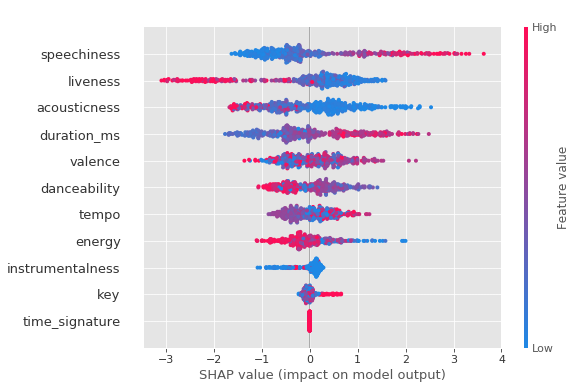

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [12]:
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
validation_pred_proba_grad = model2.predict_proba(X_validation)
roc_auc_score(y_validation, validation_pred_proba_grad[:,1])

0.8767289600813628

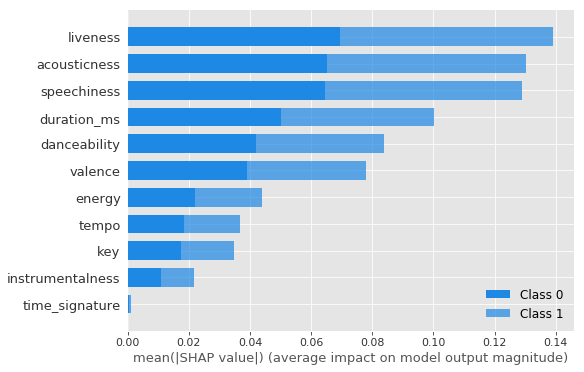

In [14]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

NameError: name 'sp' is not defined